## Dataset

In [1]:
from lale.lib.aif360 import fetch_adult_df
(train_X, train_y), (test_X, test_y) = fetch_adult_df(test_size=0.8)

In [2]:
import pandas as pd
print(f'train_X.shape {train_X.shape}')
pd.options.display.max_columns = None
pd.concat([train_y.head(10), train_X.head(10)], axis=1)

train_X.shape (9768, 100)


,class,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,native-country_Cambodia,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,sex,race
43764,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,36.0,160035.0,9.0,0.0,0.0,40.0,1.0,1.0
15818,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,50.0,61735.0,10.0,0.0,0.0,25.0,1.0,1.0
38390,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,66.0,186030.0,4.0,0.0,0.0,32.0,1.0,1.0
8809,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,55.0,120910.0,9.0,0.0,0.0,40.0,0.0,1.0
46458,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,

In [3]:
fairness_info = {
    'favorable_label': 1.0,
    'unfavorable_label': 0.0,
    'protected_attribute_names': ['race', 'sex'],
    'unprivileged_groups': [{'race': 0.0, 'sex': 0.0}],
    'privileged_groups': [{'race': 1.0, 'sex': 1.0}]}

## Search Initial Pipeline

In [4]:
from sklearn.decomposition import PCA
from lale.lib.lale import NoOp
from sklearn.linear_model import LogisticRegression as LR
from xgboost import XGBClassifier as XGBoost
import lale
lale.wrap_imported_operators()

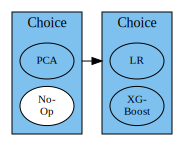

In [5]:
initial_planned = (PCA | NoOp) >> (LR | XGBoost)
initial_planned.visualize()

In [6]:
from lale.lib.lale import Hyperopt
initial_trained = initial_planned.auto_configure(
    train_X, train_y, optimizer=Hyperopt, cv=3, max_evals=3)

100%|█████████| 3/3 [01:44<00:00, 34.75s/trial, best loss: -0.8434684684684685]
1 out of 3 trials failed, call summary() for details.
Run with verbose=True to see per-trial exceptions.


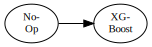

```python
xg_boost = XGBoost(
    gamma=0.17622130660514113,
    learning_rate=0.18341190121041187,
    max_depth=6,
    min_child_weight=7,
    n_estimators=985,
    reg_alpha=0.31944725103976734,
    reg_lambda=0.1621462067862438,
    subsample=0.8343057119918101,
)
pipeline = NoOp() >> xg_boost
```

In [7]:
initial_trained.visualize()
initial_trained.pretty_print(ipython_display=True, show_imports=False)

## Evaluate Initial Pipeline

In [8]:
#accuracy, ideal 100%, higher values indicate better predictive performance
import sklearn.metrics
accuracy_scorer = sklearn.metrics.make_scorer(sklearn.metrics.accuracy_score)
print(f'accuracy {accuracy_scorer(initial_trained, test_X, test_y):.1%}')

accuracy 84.6%


In [9]:
#statistical parity difference, ideal 0, fair between -0.1 and +0.1
stat_par_scorer = lale.lib.aif360.statistical_parity_difference(**fairness_info)
print(f'statistical parity difference {stat_par_scorer(initial_trained, test_X, test_y):.2f}')

statistical parity difference -0.25


In [10]:
#disparate impact, ideal 1, fair between 0.8 and 1.2
disparate_impact_scorer = lale.lib.aif360.disparate_impact(**fairness_info)
print(f'disparate impact {disparate_impact_scorer(initial_trained, test_X, test_y):.2f}')

disparate impact 0.17


## Equalized Odds Postprocessing

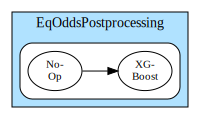

In [11]:
from lale.lib.aif360 import EqOddsPostprocessing
eqodds_trainable = EqOddsPostprocessing(
    estimator=initial_trained, **fairness_info)
eqodds_trainable.visualize()

In [12]:
%%time
eqodds_trained = eqodds_trainable.fit(train_X, train_y)

CPU times: user 47.4 s, sys: 203 ms, total: 47.6 s
Wall time: 48.7 s


In [13]:
print(f'accuracy {accuracy_scorer(eqodds_trained, test_X, test_y):.1%}')
print(f'statistical parity difference {stat_par_scorer(eqodds_trained, test_X, test_y):.2f}')
print(f'disparate impact {disparate_impact_scorer(eqodds_trained, test_X, test_y):.2f}')

accuracy 82.9%
statistical parity difference -0.26
disparate impact 0.13


## Calibrated Equalized Odds Postprocessing

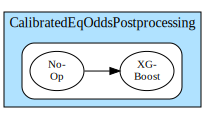

In [14]:
from lale.lib.aif360 import CalibratedEqOddsPostprocessing
caleqo_trainable = CalibratedEqOddsPostprocessing(
    estimator=initial_trained, **fairness_info)
caleqo_trainable.visualize()

In [15]:
%%time
caleqo_trained = caleqo_trainable.fit(train_X, train_y)

CPU times: user 45.4 s, sys: 219 ms, total: 45.6 s
Wall time: 45.9 s


In [16]:
print(f'accuracy {accuracy_scorer(caleqo_trained, test_X, test_y):.1%}')
print(f'statistical parity difference {stat_par_scorer(caleqo_trained, test_X, test_y):.2f}')
print(f'disparate impact {disparate_impact_scorer(caleqo_trained, test_X, test_y):.2f}')

accuracy 82.8%
statistical parity difference -0.23
disparate impact 0.18


## Reject Option Classification Postprocessing

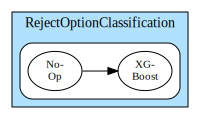

In [17]:
from lale.lib.aif360 import RejectOptionClassification
rejopt_trainable = RejectOptionClassification(
    estimator=initial_trained, **fairness_info)
rejopt_trainable.visualize()

In [18]:
%%time
rejopt_trained = rejopt_trainable.fit(train_X, train_y)

CPU times: user 1min 30s, sys: 1.14 s, total: 1min 31s
Wall time: 1min 33s


In [19]:
print(f'accuracy {accuracy_scorer(rejopt_trained, test_X, test_y):.1%}')
print(f'statistical parity difference {stat_par_scorer(rejopt_trained, test_X, test_y):.2f}')
print(f'disparate impact {disparate_impact_scorer(rejopt_trained, test_X, test_y):.2f}')

accuracy 84.6%
statistical parity difference -0.25
disparate impact 0.17
